## Introducción

Este proyecto analiza la actividad mensual de usuarios en una aplicación educativa similar a Duolingo, durante enero de 2024.
El objetivo principal fue comprender los patrones de uso de la app, comparar el comportamiento entre usuarios **Premium** y **Gratuitos**, y finalmente, segmentar a los usuarios según su nivel de actividad mensual mediante un modelo de **K-Means**.

Este análisis busca aportar información útil para estrategias de **retención**, **engagement** y **personalización de contenidos**, elementos clave en productos digitales educativos.

---

## 1. Limpieza de Datos

Se verificó la estructura de la base, asegurando que las fechas estuvieran en formato correcto (`yyyy-mm-dd`) y que no existieran valores negativos en las variables numéricas (`lessons_completed`, `minutes_spent`, `quizzes_attempted`).
Los resultados mostraron que la base de datos era **coherente, sin errores estructurales ni valores anómalos**, por lo que se consideró **lista para el análisis**.

*Nota:* No se eliminaron duplicados, ya que cada fila representaba una actividad diaria de un usuario.

---

## 2. Análisis Exploratorio Diario

A través de medidas descriptivas se identificó que:

* El 75 % de los usuarios completan **una lección o menos al día**.
* El 75 % dedica **menos de 43 minutos diarios** al estudio.
* La mayoría **no realiza quizzes** con frecuencia.

Las distribuciones y boxplots mostraron que algunos usuarios son **atípicos** por realizar más de 5 lecciones o 2 quizzes diarios.
La correlación entre minutos, lecciones y quizzes fue **débil**, aunque se observó una relación **tendencial positiva**: mayor tiempo invertido implica completar mas lecciones e intentar quizzes.

---

## 3. Análisis de Actividad Mensual

Se consolidó la información a nivel **usuario**, sumando el total mensual de lecciones, quizzes, minutos y días activos.
Además, se calcularon **rachas de uso continuo**, un indicador clave del compromiso del usuario con la plataforma.

### Principales hallazgos mensuales:

* El 75 % completa menos de **40 lecciones mensuales**.
* Dedican menos de **16 horas mensuales** de estudio.
* Están activos **menos de 24 días** al mes.
* Mantienen **rachas promedio de menos de 4 días**.

Este patrón muestra que la mayoría de los usuarios presentan **hábitos intermitentes**, aunque una minoría logra mantener constancia.

El 56 % de los usuarios cuenta con una **suscripción gratuita**, lo que confirma que el público principal aún no es de pago.

---

## 4. Comparación entre Usuarios Premium y Gratuitos

Se aplicó la **prueba de Mann–Whitney U**, una prueba no paramétrica adecuada para comparar grupos independientes con distribuciones no normales.

Los resultados mostraron **diferencias estadísticamente significativas (p < 0.001)** con un **tamaño del efecto fuerte (r ≈ 0.8)** en:

* Lecciones completadas
* Minutos invertidos
* Quizzes intentados

Esto evidencia que los usuarios **Premium son mucho más activos** que los Gratuitos, validando la relevancia de incluir `subscription_type` como variable predictora en modelos posteriores.

---

## 5. Segmentación con K-Means

Se estandarizaron las variables numéricas y se aplicó el método del **codo (KElbowVisualizer)** para determinar el número óptimo de clusters.
El resultado fue **K = 3**, representando tres perfiles distintos de usuarios:

| Segmento      | Descripción                      | Actividad promedio                                         |
| ------------- | -------------------------------- | ---------------------------------------------------------- |
| **Bajo**      | Usuarios con baja interacción    | 19 lecciones, 6 h de estudio, 9 quizzes, 19 días activos   |
| **Moderado**  | Usuarios regulares y constantes  | 23 lecciones, 7 h de estudio, 12 quizzes, 23 días activos  |
| **Intensivo** | Usuarios altamente comprometidos | 42 lecciones, 16 h de estudio, 31 quizzes, 22 días activos |

Estos grupos permiten **entender distintos niveles de compromiso** y pueden ser utilizados por el área de producto o marketing para diseñar estrategias específicas (por ejemplo, incentivos para que los usuarios de nivel bajo incrementen su participación, como la agregación de mascotas virtuales).

---

## 6. Conclusiones clave

* Los usuarios **Premium** muestran un compromiso significativamente mayor.
* La variable `subscription_type` tiene **poder explicativo** sobre la actividad en la app.
* La segmentación en tres grupos permite **personalizar estrategias de retención**.
* El análisis de rachas aporta una métrica valiosa de **consistencia en el uso**.

---
# Código:


# Librerias

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Datos

In [17]:
path = r'../tablas/user_activity.csv'
data = pd.read_csv(path)

In [18]:
data.head(4)

,user_id,date,lessons_completed,minutes_spent,quizzes_attempted,subscription_type
0,1,2024-01-01,1,22,0,Gratuito
1,1,2024-01-03,3,9,0,Gratuito
2,1,2024-01-04,1,24,1,Gratuito
3,1,2024-01-05,0,26,0,Gratuito


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            2192 non-null   int64 
 1   date               2192 non-null   object
 2   lessons_completed  2192 non-null   int64 
 3   minutes_spent      2192 non-null   int64 
 4   quizzes_attempted  2192 non-null   int64 
 5   subscription_type  2192 non-null   object
dtypes: int64(4), object(2)
memory usage: 102.9+ KB


# 2. Limpieza

Revisaremos si la base de datos esta bien estructurada y limpia.

In [20]:
# Funcion que convierte cada fila en formato yyyy-mm-dd
def formato_yyyy_mm_dd(fecha):
    try:
        pd.to_datetime(fecha, format='%Y-%m-%d')
        return True
    except ValueError:
        return False

result = data['date'].apply(formato_yyyy_mm_dd)


##########################################################

# Valores negativos en columnas numericas
values = []
cols = data.columns[2:5] #Columnas numericas

for col in cols:
    negative_val = (data[col]<0).sum() #Condicional negativo
    values.append([col,negative_val])

##########################################################

#Resumen
print('tipos de subscripcion: ', data['subscription_type'].unique())
print('=============================================')
print('Valores null por columna:\n')
print(data.isnull().sum())
print('=============================================')
print('El formato de fecha es:')
if data.shape[0] == result.sum():
    print('Formato de fecha correcto')
print('=============================================')
print('Resumen de valores negativos por columna: ')
pd.DataFrame(values,columns=['column','negative_values'])


tipos de subscripcion:  ['Gratuito' 'Premium']
Valores null por columna:

user_id              0
date                 0
lessons_completed    0
minutes_spent        0
quizzes_attempted    0
subscription_type    0
dtype: int64
El formato de fecha es:
Formato de fecha correcto
Resumen de valores negativos por columna: 


,column,negative_values
0,lessons_completed,0
1,minutes_spent,0
2,quizzes_attempted,0


Podemos concluir que la base de datos tiene estructura y esta lista para usarse (no se tomaron en cuenta los valores duplicados, debido a que se trata de los registros de una app de estudio)

# 3. Análisis exploratorio.

## 3.1 Diario

In [21]:
#Numerico
data[cols].describe()

,lessons_completed,minutes_spent,quizzes_attempted
count,2192.000000,2192.000000,2192.000000
mean,1.410128,30.770529,0.919708
std,1.271873,15.900328,1.052234
min,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000
50%,1.000000,30.000000,1.000000
75%,2.000000,43.000000,1.000000
max,7.000000,76.000000,6.000000


Conclusiones:

El 75% de los estudiantes completan al día una leccion

El 75% de los estudiantes dedican al día menos de 43 min de estudio (uso de la app)

El 75% de los estudiantes no intentan completar quizzes

### 3.1.1 Distribución y datos atípicos

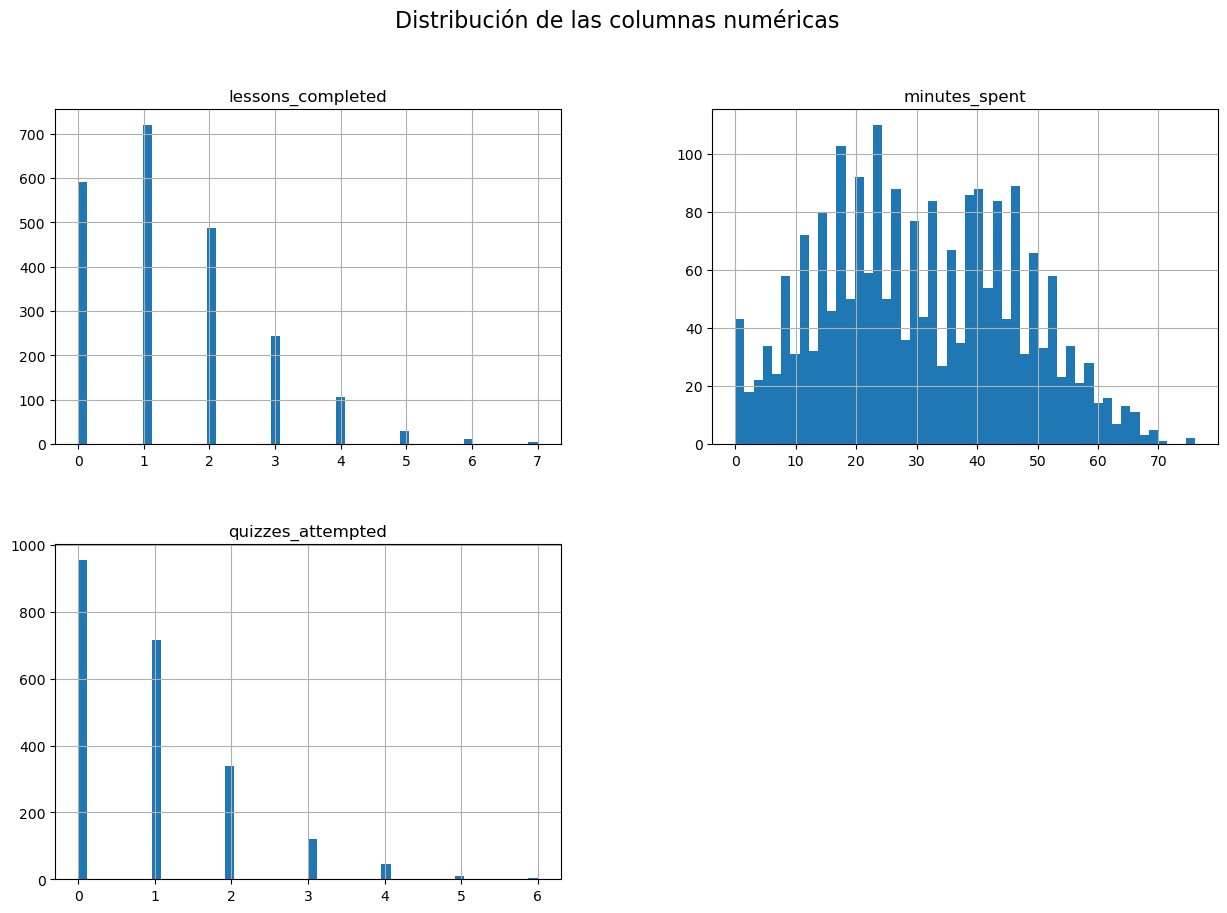

In [22]:
data[cols].hist(bins=50, figsize=(15,10))
plt.suptitle('Distribución de las columnas numéricas', fontsize=16)
plt.show()


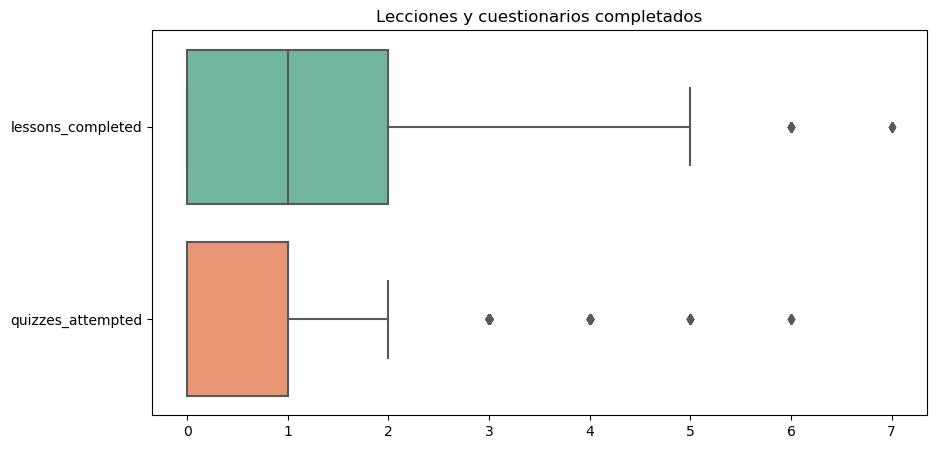

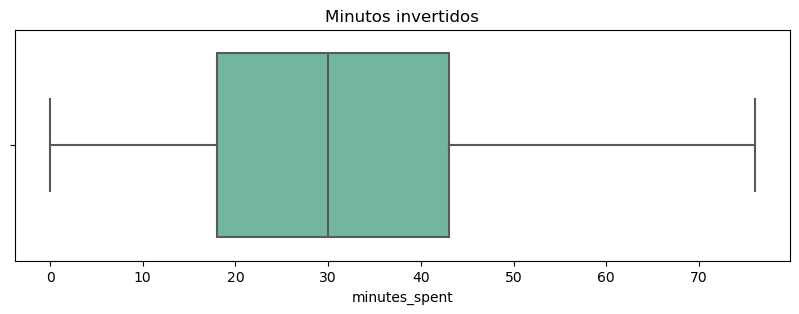

In [23]:
# Figura 1:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data[['lessons_completed', 'quizzes_attempted']], orient='h', palette='Set2')
plt.title('Lecciones y cuestionarios completados')
plt.show()

# Figura: 2
plt.figure(figsize=(10, 3))
sns.boxplot(x=data['minutes_spent'], orient='h', palette='Set2')
plt.title('Minutos invertidos')
plt.show()

Aquellos alumnos que realizan más de 5 lecciones al día, se consideran como estudiantes atipicos.

Aquellos alumnos que terminan al día más de 2 quizzes se consideran alumnos atípicos

In [24]:
corr_matriz = data[cols].corr(numeric_only=True)
corr_matriz

,lessons_completed,minutes_spent,quizzes_attempted
lessons_completed,1.000000,0.261285,0.173309
minutes_spent,0.261285,1.000000,0.341176
quizzes_attempted,0.173309,0.341176,1.000000


In [25]:
cov_matriz = data[cols].cov(numeric_only=True)
cov_matriz

,lessons_completed,minutes_spent,quizzes_attempted
lessons_completed,1.617661,5.284023,0.231941
minutes_spent,5.284023,252.820436,5.708176
quizzes_attempted,0.231941,5.708176,1.107197


No existe relación FUERTE entre los minutos dedicados al día y el número de quizes o lecciones realizadas, pese ha esto, si un alumno aumenta su tiempo dedicado en la app estas variables mostraran una dependencia creciente, es decir, si un alumno dedica más tiempo en la app aumentara el número de quizes y lecciones completadas al día

## 3.2 Tabla resumen.

In [26]:
resume_data = data.groupby('user_id').agg({
    'lessons_completed': 'sum',
    'minutes_spent': 'sum',
    'quizzes_attempted': 'sum',
    'subscription_type': 'last',
    'date': 'nunique'  
}).reset_index().rename(columns={'date': 'days_active'}) 

resume_data

,user_id,lessons_completed,minutes_spent,quizzes_attempted,subscription_type,days_active
0,1,17,335,6,Gratuito,23
1,2,42,1094,24,Premium,25
2,3,25,529,14,Gratuito,24
3,4,18,414,10,Gratuito,23
4,5,20,483,7,Gratuito,21
...,...,...,...,...,...,...
95,96,24,410,15,Gratuito,24
96,97,25,436,12,Gratuito,26
97,98,24,453,18,Gratuito,23
98,99,42,1065,46,Premium,24


In [27]:
days_active = data.groupby('user_id')['date'].nunique()
days_active

user_id
1      23
2      25
3      24
4      23
5      21
       ..
96     24
97     26
98     23
99     24
100    23
Name: date, Length: 100, dtype: int64

## 3.3 Cálculo de rachas

In [28]:
#Definimos una serie de tiempo:
serie_time = data[['user_id','date']].copy()
serie_time['date'] = pd.to_datetime(serie_time['date'], format='%Y-%m-%d')
serie_time

,user_id,date
0,1,2024-01-01
1,1,2024-01-03
2,1,2024-01-04
3,1,2024-01-05
4,1,2024-01-06
...,...,...
2187,100,2024-01-26
2188,100,2024-01-27
2189,100,2024-01-28
2190,100,2024-01-29


In [29]:
# Calculamos la diferencia de dias entre el registro anterior y el actual
serie_time['date_diff'] = serie_time.groupby('user_id')['date'].diff().dt.days
serie_time

,user_id,date,date_diff
0,1,2024-01-01,NaN
1,1,2024-01-03,2.0
2,1,2024-01-04,1.0
3,1,2024-01-05,1.0
4,1,2024-01-06,1.0
...,...,...,...
2187,100,2024-01-26,1.0
2188,100,2024-01-27,1.0
2189,100,2024-01-28,1.0
2190,100,2024-01-29,1.0


In [30]:
#Registramos valores booleanos para analizar el inicio de rachas por usuario
#(serie_time['user_id'] != serie_time['user_id'].shift(1): Ayuda a identificar cambios de usuario

serie_time['new_streak'] = (serie_time['date_diff'] != 1) | (serie_time['user_id'] != serie_time['user_id'].shift(1)) 
serie_time

,user_id,date,date_diff,new_streak
0,1,2024-01-01,NaN,True
1,1,2024-01-03,2.0,True
2,1,2024-01-04,1.0,False
3,1,2024-01-05,1.0,False
4,1,2024-01-06,1.0,False
...,...,...,...,...
2187,100,2024-01-26,1.0,False
2188,100,2024-01-27,1.0,False
2189,100,2024-01-28,1.0,False
2190,100,2024-01-29,1.0,False


In [31]:
#Calculo del numero de rachas asignando id's a las nuevas rachas.
serie_time['streak_id'] = serie_time.groupby('user_id')['new_streak'].cumsum() 
serie_time.head(10)

,user_id,date,date_diff,new_streak,streak_id
0,1,2024-01-01,NaN,True,1
1,1,2024-01-03,2.0,True,2
2,1,2024-01-04,1.0,False,2
3,1,2024-01-05,1.0,False,2
4,1,2024-01-06,1.0,False,2
5,1,2024-01-07,1.0,False,2
6,1,2024-01-08,1.0,False,2
7,1,2024-01-10,2.0,True,3
8,1,2024-01-11,1.0,False,3
9,1,2024-01-12,1.0,False,3


In [32]:
#calculos de las longitudes de las rachas (cuantos dias tuvo cada racha) por usuario.
streaks = serie_time.groupby(['user_id','streak_id']).size().reset_index(name='streak_lenght')
streaks

,user_id,streak_id,streak_lenght
0,1,1,1
1,1,2,6
2,1,3,8
3,1,4,1
4,1,5,1
...,...,...,...
666,100,2,6
667,100,3,5
668,100,4,3
669,100,5,7


In [33]:
# Resumen resultados
def moda(serie):
    modas = serie.mode()
    if modas.empty:
        return None
    else:
        return modas.iloc[0]

streak_resumen = streaks.groupby('user_id').agg(
    streak_Min=('streak_lenght', 'min'),
    streak_Max=('streak_lenght', 'max'),
    streak_Mode=('streak_lenght', moda),
    strek_Average=('streak_lenght', 'mean')
).reset_index()
streak_resumen = streak_resumen.round(0)
streak_resumen

,user_id,streak_Min,streak_Max,streak_Mode,strek_Average
0,1,1,8,1,3.0
1,2,1,12,4,5.0
2,3,2,7,2,4.0
3,4,1,8,2,3.0
4,5,1,11,1,3.0
...,...,...,...,...,...
95,96,3,14,3,8.0
96,97,1,15,1,4.0
97,98,1,8,1,5.0
98,99,1,7,3,4.0


## 3.4 Tabla resumen de actividad por usuario

In [34]:
user_actResume = resume_data.merge(streak_resumen, on= 'user_id', how='left')
user_actResume

,user_id,lessons_completed,minutes_spent,quizzes_attempted,subscription_type,days_active,streak_Min,streak_Max,streak_Mode,strek_Average
0,1,17,335,6,Gratuito,23,1,8,1,3.0
1,2,42,1094,24,Premium,25,1,12,4,5.0
2,3,25,529,14,Gratuito,24,2,7,2,4.0
3,4,18,414,10,Gratuito,23,1,8,2,3.0
4,5,20,483,7,Gratuito,21,1,11,1,3.0
...,...,...,...,...,...,...,...,...,...,...
95,96,24,410,15,Gratuito,24,3,14,3,8.0
96,97,25,436,12,Gratuito,26,1,15,1,4.0
97,98,24,453,18,Gratuito,23,1,8,1,5.0
98,99,42,1065,46,Premium,24,1,7,3,4.0


## 3.6 Análisis mensual

In [35]:
columns = list(user_actResume.columns[1:4]) + ['days_active','strek_Average']

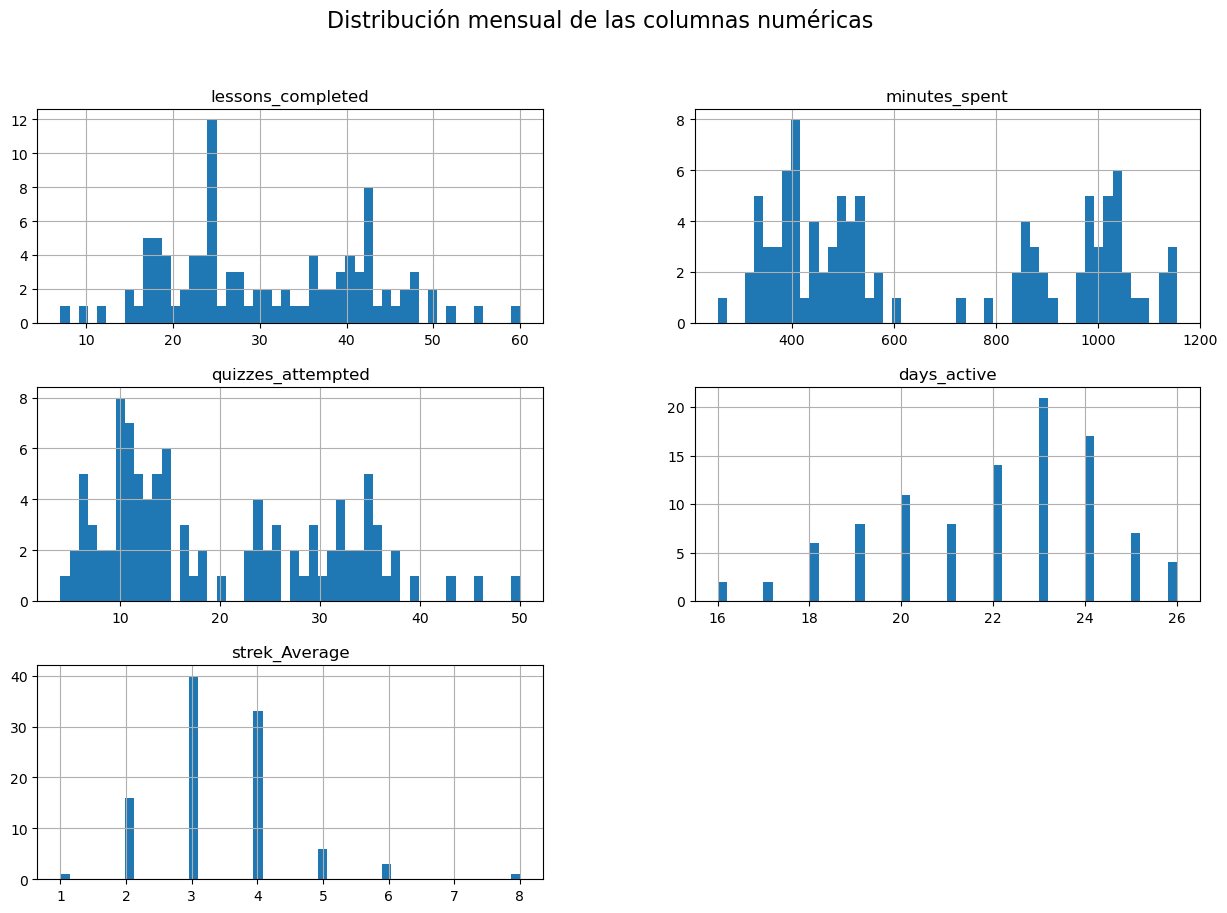

In [36]:
user_actResume[columns].hist(bins=50, figsize=(15,10))
plt.suptitle('Distribución mensual de las columnas numéricas', fontsize=16)
plt.show()

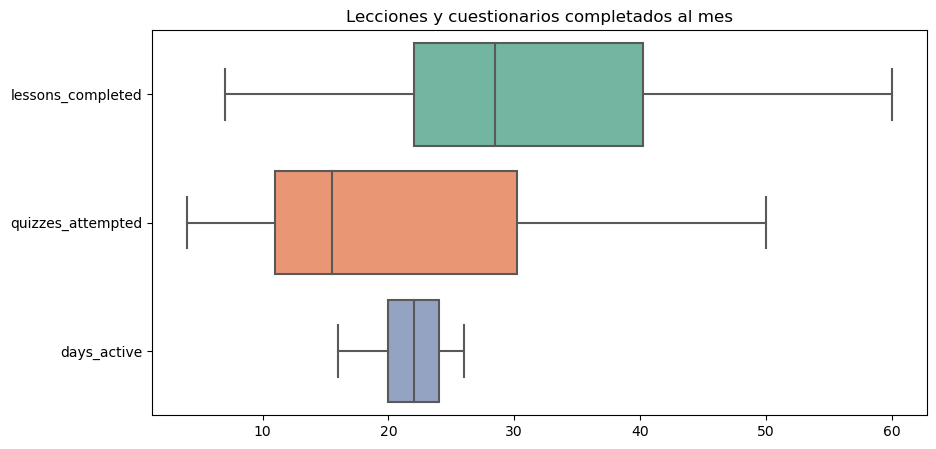

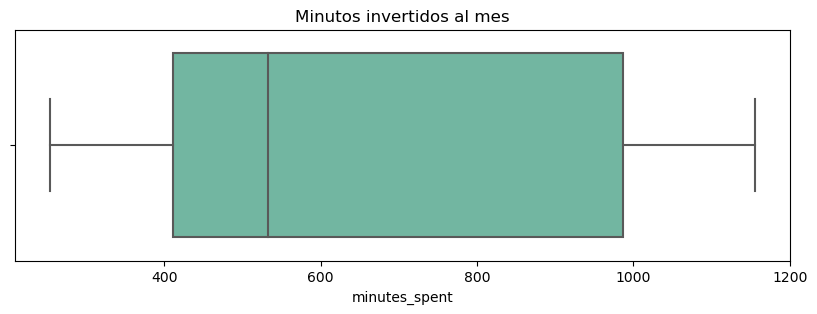

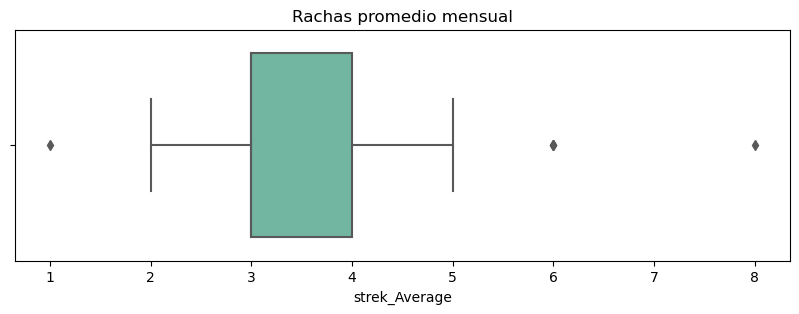

In [37]:
# Figura 1:
plt.figure(figsize=(10, 5))
sns.boxplot(data=user_actResume[['lessons_completed', 'quizzes_attempted','days_active']], orient='h', palette='Set2')
plt.title('Lecciones y cuestionarios completados al mes')
plt.show()

# Figura: 2
plt.figure(figsize=(10, 3))
sns.boxplot(x=user_actResume['minutes_spent'], orient='h', palette='Set2')
plt.title('Minutos invertidos al mes')
plt.show()

# Figura: 3
plt.figure(figsize=(10, 3))
sns.boxplot(x=user_actResume['strek_Average'], orient='h', palette='Set2')
plt.title('Rachas promedio mensual')
plt.show()

Aquellos alumnos que en promedio solo consiguen mantener una racha de 1 día, se consideran atípicos, lo que nos dice que los alumnos tienden a estar activos en la aplicación de manera continua.

Aquellos alumnos que mantengan rachas de mas de 5 días, se consideran atípicos.

In [38]:
#Numerico
user_actResume[columns].describe()

,lessons_completed,minutes_spent,quizzes_attempted,days_active,strek_Average
count,100.00000,100.000000,100.000000,100.000000,100.000000
mean,30.91000,674.490000,20.160000,21.920000,3.410000
std,11.43457,286.203978,11.275897,2.372741,1.064534
min,7.00000,254.000000,4.000000,16.000000,1.000000
25%,22.00000,410.750000,11.000000,20.000000,3.000000
50%,28.50000,532.500000,15.500000,22.000000,3.000000
75%,40.25000,986.500000,30.250000,24.000000,4.000000
max,60.00000,1155.000000,50.000000,26.000000,8.000000


Conclusiones:

El 75% de los estudiantes completan al mes menos de 40 lecciones

El 75% de los estudiantes dedican al mes menos de 16 h de estudio (uso de la app)

El 75% de los estudiantes completan al mes menos de 30 quizes un quizzes

El 75% de los estudiantes permanecen activos menos de 24 dias

El 75% de los estudiantes mantienen rachas de menos de 4 dias

In [39]:
# Categorico
user_actResume['subscription_type'].describe()

count          100
unique           2
top       Gratuito
freq            56
Name: subscription_type, dtype: object

El 56% de los estudiantes tienen suscripcion Gratuita 

## 3.5 Análisis por tipo de suscripción

In [40]:
#Primero analizaremos si es que hubo algun usuario que cambio su tipo de suscripcion en algun dia del mes:

cambio_subs = data[['user_id', 'subscription_type']].drop_duplicates() 

if not(cambio_subs.user_id.duplicated().any()):
    print('No hubo cambios de suscripcion') 

No hubo cambios de suscripcion


Nos interesa saber si existe alguna diferencia entre los usuarios que tienen suscripción premium y gratuita.
Este analisis nos ayudara a tomar en cuenta esta variable en modelos futuros.

In [41]:
import scipy.stats as stats

free = user_actResume[user_actResume['subscription_type'] == 'Gratuito']
premium = user_actResume[user_actResume['subscription_type'] == 'Premium']

for var in columns:
    # Prueba Mann-Whitney
    stat, p = stats.mannwhitneyu(free[var], premium[var], alternative='two-sided')
    
    # Cálculo del tamaño del efecto (r)
    n1, n2 = len(free[var].dropna()), len(premium[var].dropna())
    mean_U = n1 * n2 / 2
    std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z = (stat - mean_U) / std_U
    r = abs(z) / np.sqrt(n1 + n2)
    
    # Resultado
    print(f"{var:<20} | U={stat:>10.2f} | p-value={p:>8.4f} | r={r:>6.3f}")


lessons_completed    | U=      6.50 | p-value=  0.0000 | r= 0.851
minutes_spent        | U=      0.00 | p-value=  0.0000 | r= 0.856
quizzes_attempted    | U=      5.00 | p-value=  0.0000 | r= 0.852
days_active          | U=   1233.50 | p-value=  0.9944 | r= 0.001
strek_Average        | U=   1368.50 | p-value=  0.3184 | r= 0.095


Concluimos que para las variables:
- lessons_completed	
- minutes_spent	
- quizzes_attempted	

Existe una diferencia significativa entre los usuarios Premium y Gratuitos con un tamaño de efecto fuerte ($r \approx 0.8$).
En conclusion los usuarios con suscripcion `Premium` y `Gratuito` son significativamente diferentes.

Tiene sentido que tomemos la variable ``subscription_type`` para nuestro modelo.

# 4. Modelo KMeans

Para la realizacion de este modelo nos enfocaremos en las siguientes variables:

- lessons_completed	
- minutes_spent	
- quizzes_attempted	
- subscription_type	
- days_active 
- strek_Average

In [42]:
# Obtenemos los datos de la tabla de resumen
data_model = user_actResume[['user_id','lessons_completed', 
                             'minutes_spent', 
                             'quizzes_attempted', 
                             'subscription_type', 
                             'days_active',
                             'strek_Average'
                             ]].copy()

data_model = data_model.set_index('user_id')
data_model.head(4)

,lessons_completed,minutes_spent,quizzes_attempted,subscription_type,days_active,strek_Average
user_id,,,,,,
1,17,335,6,Gratuito,23,3.0
2,42,1094,24,Premium,25,5.0
3,25,529,14,Gratuito,24,4.0
4,18,414,10,Gratuito,23,3.0


In [43]:
#Preprocesamiento de la tabla
from sklearn.preprocessing import StandardScaler

# Convertimos categoricos a numericos
data_model.replace({'Gratuito': 1,'Premium':0}, inplace=True)


escalador = StandardScaler()
data_normalizado = escalador.fit_transform(data_model)

# Convertir a DataFrame
data_estandar = pd.DataFrame(data_normalizado, 
                                index=data_model.index, 
                                columns=data_model.columns)

## 4.1 Optimización de hiperparámetro (Gráfica de codo)

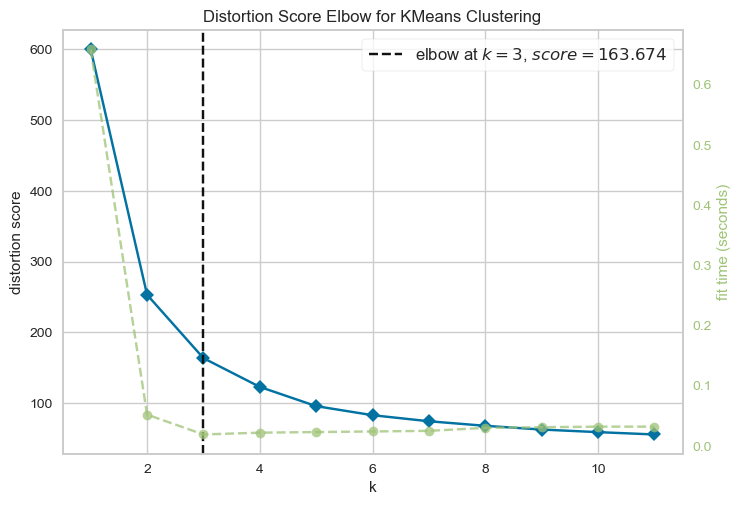

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

modelos = KMeans(n_init=10,random_state=42)

visualizer = KElbowVisualizer(modelos, k=(1,12)) 


visualizer.fit(data_estandar)
visualizer.show()

Es optimo establecer  $K=3$

## 4.2 Modelo 

In [45]:
k_medias = KMeans(n_clusters = 3 ,init='k-means++',max_iter=300, 
                          random_state= 111  , algorithm='elkan')

In [46]:
k_medias.fit(data_estandar)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,111
,copy_x,True
,algorithm,'elkan'


In [47]:
data_estandar['cluster'] = k_medias.labels_
data_model['cluster'] = k_medias.labels_

data_model.head(10)

,lessons_completed,minutes_spent,quizzes_attempted,subscription_type,days_active,strek_Average,cluster
user_id,,,,,,,
1,17,335,6,1,23,3.0,2
2,42,1094,24,0,25,5.0,1
3,25,529,14,1,24,4.0,2
4,18,414,10,1,23,3.0,2
5,20,483,7,1,21,3.0,0
6,48,997,24,0,22,3.0,1
7,33,536,10,1,25,5.0,2
8,23,386,18,1,21,3.0,0
9,36,860,24,0,20,3.0,1


In [48]:
# Estadísticas por clasificacion
cluster_profile = data_model.groupby('cluster').agg({
    'lessons_completed': ['max','min','mean'],
    'minutes_spent': ['max','min','mean'],
    'quizzes_attempted': ['max','min','mean'],
   'days_active': ['max','min','mean'],
    'strek_Average': ['max','min','mean']
}).reset_index()

cluster_profile['class'] = ['Bajo','Intensivos','Moderado']
cluster_profile

cluster lessons_completed                minutes_spent                   \
                        max min       mean           max  min        mean   
0       0                27   7  19.285714           483  254  369.238095   
1       1                60  30  42.045455          1155  730  979.727273   
2       2                33  15  23.885714           602  330  473.914286   

  quizzes_attempted                days_active                strek_Average  \
                max min       mean         max min       mean           max   
0                18   5   9.095238          22  16  19.047619           3.0   
1                50  16  31.431818          26  17  22.000000           5.0   
2                20   4  12.628571          26  21  23.542857           8.0   

                       class  
   min      mean              
0  1.0  2.428571        Bajo  
1  2.0  3.250000  Intensivos  
2  3.0  4.200000    Moderado

Hemos segmentado a nuestros usuarios en 3 grupos según su actividad en la app:

- Bajo:
  - Aquellos alumnos que tienen una media mensual de: 
    - 19 lecciones completadas
    - 369 minutos invertidos (6 horas)
    - 9 quizzes intentados
    - 19  días activo
    - 2 días de racha
 
- Moderado:
  - Aquellos alumnos que tienen una media mensual de: 
    - 23 lecciones completadas
    - 474 minutos invertidos (7 horas)
    - 12 quizzes intentados
    - 23  días activo
    - 4 días de racha

- Intensivo:
  - Aquellos alumnos que tienen una media mensual de: 
    - 42 lecciones completadas
    - 980 minutos invertidos (16 horas)
    - 31 quizzes intentados
    - 22  días activo
    - 3 días de racha

In [49]:
# Guardamos el modelo y el escalador
import joblib

joblib.dump(k_medias, "kmeans_segmentacion_estudiantes_2025-21-10.pkl")
joblib.dump(escalador, "scaler_metricas_actividad_estudiantes_2025-21-10.pkl")

['scaler_metricas_actividad_estudiantes_2025-21-10.pkl']

In [51]:
#Guardamos resumen mensual
data_model.to_csv(f'resumen_actividad_usuario_mensual.csv', index=True)